In [ ]:
# #Donwload the datasets
!rm -rf data/
!mkdir data/

!wget https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/sudoku/v0.1/train.tar.gz
!wget https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/sudoku/v0.1/test.tar.gz

In [ ]:
!tar xvzf train.tar.gz -C data/
!tar xvzf test.tar.gz -C data/

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import model_from_json
from google.colab.patches import cv2_imshow
from time import time
from csv import writer
import os

In [ ]:
def plt_img(img, title='Image'):
  plt.figure(figsize = (10,10))
  plt.imshow(img, cmap='gray')
  plt.title(title)
  plt.show()

In [ ]:
def displayGrid(image):
    cell_height = image.shape[0] // 9
    cell_width = image.shape[1] // 9
    indentation = 0
    rects = []
    
    for i in range(9):
        for j in range(9):
            p1 = (j*cell_height + indentation, i*cell_width + indentation)
            p2 = ((j+1)*cell_height - indentation, (i+1)*cell_width - indentation)
            rects.append((p1, p2))
            cv2.rectangle(image, p1, p2, (0, 255, 0), 3)
    return rects

#Preprocesses the input image...
def preprocessImage(image, skip_dilation = False):
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype = np.uint8)
    preprocess = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    preprocess = cv2.GaussianBlur(preprocess, (9, 9), 0)
    preprocess = cv2.adaptiveThreshold(preprocess, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    # preprocess = cv2.erode(preprocess, kernel, iterations = 1)
    # cv2_imshow(preprocess)
    if not skip_dilation:
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype = np.uint8)
        # preprocess = cv2.dilate(preprocess, kernel, iterations = 1)

    return preprocess

#Gets the coords of the corner points of largest rectangle...
def getCoords(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    all_contours = sorted(contours, key = cv2.contourArea, reverse = True)
    polygon = all_contours[0]
    sums = []
    diffs = []
    
    for point in polygon:
        for x, y in point:
            sums.append(x + y)
            diffs.append(x - y)
            
    top_left = polygon[np.argmin(sums)].squeeze()
    bottom_right = polygon[np.argmax(sums)].squeeze() 
    top_right = polygon[np.argmax(diffs)].squeeze()
    bottom_left = polygon[np.argmin(diffs)].squeeze() 
    
    return np.array([top_left, top_right, bottom_right, bottom_left], dtype = np.float32)

#Warping the image...
def warp(image, coords):
    ratio = 1.2
    tl, tr, br, bl = coords
    widthA = np.sqrt((tl[1] - tr[1])**2 + (tl[0] - tr[1])**2)
    widthB = np.sqrt((bl[1] - br[1])**2 + (bl[0] - br[1])**2)
    heightA = np.sqrt((tl[1] - bl[1])**2 + (tl[0] - bl[1])**2)
    heightB = np.sqrt((tr[1] - br[1])**2 + (tr[0] - br[1])**2)
    width = max(widthA, widthB) * ratio
    height = width
    
    destination = np.array([
        [0, 0],
        [height, 0],
        [height, width],
        [0, width]], dtype = np.float32)
    M = cv2.getPerspectiveTransform(coords, destination)
    warped = cv2.warpPerspective(image, M, (int(height), int(width)))
    return warped

#Extracting each grid image...
def extractGrid(image, rects):
    tiles = []
    for coords in rects:
        rect = image[coords[0][1]:coords[1][1], coords[0][0]:coords[1][0]]
        tiles.append(rect)
    return tiles

In [ ]:
#SINGLE IMAGE INFERENCE

%time
image = cv2.imread('data/test/images/0078.png')
image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.copyMakeBorder(image.copy(),2,2,2,2,cv2.BORDER_CONSTANT,value=[0,0,0,0])
image_bw = cv2.copyMakeBorder(image_bw.copy(),2,2,2,2,cv2.BORDER_CONSTANT,value=[0,0,0,0])
# cv2_imshow(constant)
image = cv2.resize(image,(600,600))
image_bw = cv2.resize(image_bw,(600,600))
preprocess = cv2.resize(preprocessImage(image), (600, 600))
preprocess = cv2.bitwise_not(preprocess, preprocess)
coords = getCoords(preprocess)
preprocess = cv2.cvtColor(preprocess, cv2.COLOR_GRAY2BGR)
coordsImage = preprocess.copy()
warpedImage = warp(image_bw, coords)
# warpedImage = cv2.copyMakeBorder(warpedImage,1,1,1,1,cv2.BORDER_CONSTANT,value=(0,0,0))
# cv2_imshow(warpedImage)
print(warpedImage.shape)
# cv2.imwrite('0000.png',warpedImage)

# Resize to 450 x 450
warpedImage = cv2.resize(warpedImage, (450, 450))
im = warpedImage.copy()
img = []
imgheight=im.shape[0]
imgwidth=im.shape[1]
M = imgheight//9
N = imgwidth//9
tiles = []
pad = 4
for y in range(0,imgheight,M):
    for x in range(0, imgwidth, N):
        y1 = y + M
        x1 = x + N
        tile = im[y+pad:y+M-pad,x+pad:x+N-pad]
        # print(tile.shape)
        tiles.append(tile)
        # img.append(np.concatenate(tiles[y*9:()*9],axis=1))
for i in range(0,9):
  img.append(np.concatenate(tiles[9*i:9*(i+1)],axis=1))
# img = vconcat([img[0], img[1]])
img = np.concatenate(img, axis=0)
# cv2_imshow(img)
thresh = cv2.threshold(img, 120, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
# kernel = np.ones((2, 2), np.uint8) 
# # Using cv2.erode() method  
# thresh = cv2.erode(thresh, kernel) 

cv2_imshow(img)
cv2_imshow(thresh)
# image = Image.fromarray(img.astype(np.uint8))
# image.save('test.jpg')
grid = extract_number(thresh)
display_sudoku(grid)
solution = sudoku_solver(grid)
display_sudoku(solution)
s = ''
for i in solution:
    for j in i:
      s += str(j)
print(s)
# display_sudoku(solution)
# cv2_imshow(thresh)
# plt_img(warpedImage)

In [ ]:
#BATCH OF IMAGES

path_img = 'data/test/images/'
files = [i for i in os.listdir(path_img)]
files.sort()
length = len(files)
for j in range(1500,2500):
    start_time = time()
    image = cv2.imread(path_img+files[j])
    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.copyMakeBorder(image.copy(),2,2,2,2,cv2.BORDER_CONSTANT,value=[0,0,0,0])
    image_bw = cv2.copyMakeBorder(image_bw.copy(),2,2,2,2,cv2.BORDER_CONSTANT,value=[0,0,0,0])
    # cv2_imshow(constant)
    image = cv2.resize(image,(600,600))
    image_bw = cv2.resize(image_bw,(600,600))
    preprocess = cv2.resize(preprocessImage(image), (600, 600))
    preprocess = cv2.bitwise_not(preprocess, preprocess)
    coords = getCoords(preprocess)
    preprocess = cv2.cvtColor(preprocess, cv2.COLOR_GRAY2BGR)
    coordsImage = preprocess.copy()
    warpedImage = warp(image_bw, coords)
    # warpedImage = cv2.copyMakeBorder(warpedImage,1,1,1,1,cv2.BORDER_CONSTANT,value=(0,0,0))
    # cv2_imshow(warpedImage)
    # print(warpedImage.shape)
    # cv2.imwrite('0000.png',warpedImage)

    # Resize to 450 x 450
    warpedImage = cv2.resize(warpedImage, (450, 450))
    im = warpedImage.copy()
    img = []
    imgheight=im.shape[0]
    imgwidth=im.shape[1]
    M = imgheight//9
    N = imgwidth//9
    tiles = []
    pad = 4
    for y in range(0,imgheight,M):
        for x in range(0, imgwidth, N):
            y1 = y + M
            x1 = x + N
            tile = im[y+pad:y+M-pad,x+pad:x+N-pad]
            # print(tile.shape)
            tiles.append(tile)
            # img.append(np.concatenate(tiles[y*9:()*9],axis=1))
    for i in range(0,9):
      img.append(np.concatenate(tiles[9*i:9*(i+1)],axis=1))
    # img = vconcat([img[0], img[1]])
    img = np.concatenate(img, axis=0)
    print(img.shape)
    thresh = cv2.threshold(img, 120, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    # kernel = np.ones((2, 2), np.uint8) 
  
    # # Using cv2.erode() method  
    # thresh = cv2.erode(thresh, kernel) 
    # cv2_imshow(img)
    # cv2_imshow(thresh)
    # image = Image.fromarray(img.astype(np.uint8))
    # image.save('test.jpg')
    # cv2_imshow(thresh)
    grid = extract_number(thresh)
    display_sudoku(grid)
    solution = sudoku_solver(grid)
    # print(solution)
    json_solution(solution,files[j])
    print(files[j])
sound()
    #   display_sudoku(solution)
# display_sudoku(solution)
# cv2_imshow(thresh)
# plt_img(warpedImage)

.  6  . |  8  5  . |  2  .  .
.  .  3 |  .  .  2 |  .  .  .
.  .  . |  .  .  . |  6  1  .
--------+----------+---------
3  .  2 |  .  1  . |  .  .  5
5  .  . |  .  4  . |  .  .  6
9  .  . |  .  8  . |  7  .  4
--------+----------+---------
.  9  7 |  .  .  . |  .  .  .
.  .  . |  4  .  . |  5  .  .
.  .  4 |  .  2  7 |  .  8  .
---
2473
2473.png
(378, 378)
.  8  . |  .  .  5 |  .  7  .
.  .  7 |  4  8  . |  .  .  3
.  5  . |  6  .  . |  9  .  .
--------+----------+---------
3  .  . |  .  2  . |  .  6  .
.  .  . |  .  6  . |  .  .  .
.  6  . |  .  3  . |  .  .  5
--------+----------+---------
.  .  2 |  .  .  3 |  .  4  .
7  .  . |  .  9  6 |  8  .  .
.  3  . |  8  .  . |  .  5  .
---
2474
2474.png
(378, 378)
.  1  7 |  .  2  . |  .  .  6
4  .  . |  .  .  . |  .  3  .
.  5  . |  .  .  7 |  .  .  4
--------+----------+---------
.  4  . |  8  .  2 |  3  .  .
7  .  . |  .  1  . |  .  .  8
.  .  3 |  5  .  6 |  .  7  .
--------+----------+---------
6  .  . |  9  .  . |  .  8  .
.  3  . |  .

In [ ]:
def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)
  
def identify_number(image):
    dummy =  cv2.merge((image,image,image))
    # print('dummy'+str(dummy.shape))
    image_resize = cv2.resize(dummy, (28,28))    # For plt.imshow
    image_resize_2 = image_resize.reshape(1,28,28,3)    # For input to model.predict_classes
    # print('image_resize'+str(image_resize_2.shape))
#    cv2.imshow('number', image_test_1)
    loaded_model_pred = loaded_model.predict_classes(image_resize_2 , verbose = 0)
#    print('Prediction of loaded_model: {}'.format(loaded_model_pred[0]))
    return loaded_model_pred[0]

def extract_number(sudoku):
    # print('yes')
    sudoku = cv2.resize(sudoku, (450,450))
    # original = cv2.resize(original, (450,450))

    # file_name = file_name.split('.')[0]
#    cv2.imshow('sudoku', sudoku)
    # split sudoku
    grid = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
#            image = sudoku[i*50+3:(i+1)*50-3,j*50+3:(j+1)*50-3]
            image = sudoku[i*50:(i+1)*50,j*50:(j+1)*50]
            # original_image = original[i*50:(i+1)*50,j*50:(j+1)*50]
            if image.sum() > 10000:
                grid[i][j] = identify_number(image)
                # filename = "/content/images_inference/"+str(grid[i][j]).split('.')[0]+"/"+file_name+"_file_%d_%d.jpg"%(i, j)
                # print(filename)
                # cv2.imwrite(filename,original_image)
            else:
                grid[i][j] = 0
    return grid.astype(int)

def json_solution(solution,filename):
    s = ''
    for i in solution:
        for j in i:
          s += str(j)
    # print(s)
    print(filename.split('.')[0])
    append_list_as_row('/content/drive/My Drive/new_solution.csv', [s,filename.split('.')[0]])

In [ ]:
# -*- coding: utf-8 -*-
# A Backtracking program in Python to solve Sudoku problem 

# A Utility Function to print the Grid 
def print_grid(arr): 
	for i in range(9): 
		for j in range(9): 
			print (arr[i][j])
		print ('\n') 

# Function to Find the entry in the Grid that is still not used 
# Searches the grid to find an entry that is still unassigned. If 
# found, the reference parameters row, col will be set the location 
# that is unassigned, and true is returned. If no unassigned entries 
# remain, false is returned.
# 'l' is a list variable that has been passed from the solve_sudoku function 
# to keep track of incrementation of Rows and Columns
def find_empty_location(arr,l): 
	for row in range(9): 
		for col in range(9): 
			if(arr[row][col]==0): 
				l[0]=row 
				l[1]=col 
				return True
	return False

# Returns a boolean which indicates whether any assigned entry 
# in the specified row matches the given number. 
def used_in_row(arr,row,num): 
	for i in range(9): 
		if(arr[row][i] == num): 
			return True
	return False

# Returns a boolean which indicates whether any assigned entry 
# in the specified column matches the given number. 
def used_in_col(arr,col,num): 
	for i in range(9): 
		if(arr[i][col] == num): 
			return True
	return False

# Returns a boolean which indicates whether any assigned entry 
# within the specified 3x3 box matches the given number 
def used_in_box(arr,row,col,num): 
	for i in range(3): 
		for j in range(3): 
			if(arr[i+row][j+col] == num): 
				return True
	return False

# Checks whether it will be legal to assign num to the given row,col 
# Returns a boolean which indicates whether it will be legal to assign 
# num to the given row,col location. 
def check_location_is_safe(arr,row,col,num): 
	
	# Check if 'num' is not already placed in current row, 
	# current column and current 3x3 box 
	return not used_in_row(arr,row,num) and not used_in_col(arr,col,num) and not used_in_box(arr,row - row%3,col - col%3,num) 

# Takes a partially filled-in grid and attempts to assign values to 
# all unassigned locations in such a way to meet the requirements 
# for Sudoku solution (non-duplication across rows, columns, and boxes) 
def solve_sudoku(arr): 
	
	# 'l' is a list variable that keeps the record of row and col in find_empty_location Function	 
	l=[0,0] 
	
	# If there is no unassigned location, we are done	 
	if(not find_empty_location(arr,l)): 
		return True
	
	# Assigning list values to row and col that we got from the above Function 
	row=l[0] 
	col=l[1] 
	
	# consider digits 1 to 9 
	for num in range(1,10): 
		
		# if looks promising 
		if(check_location_is_safe(arr,row,col,num)): 
			
			# make tentative assignment 
			arr[row][col]=num 

			# return, if sucess, ya! 
			if(solve_sudoku(arr)): 
				return True

			# failure, unmake & try again 
			arr[row][col] = 0
			
	# this triggers backtracking		 
	return False



# Driver main function to test above functions 
def sudoku_solver(grid):
	if(solve_sudoku(grid)):
		print('---') # print_grid(grid) -> to print the sudoku elements
	else:
		print ("No solution exists")
		sound()
	grid = grid.astype(int)
	return grid

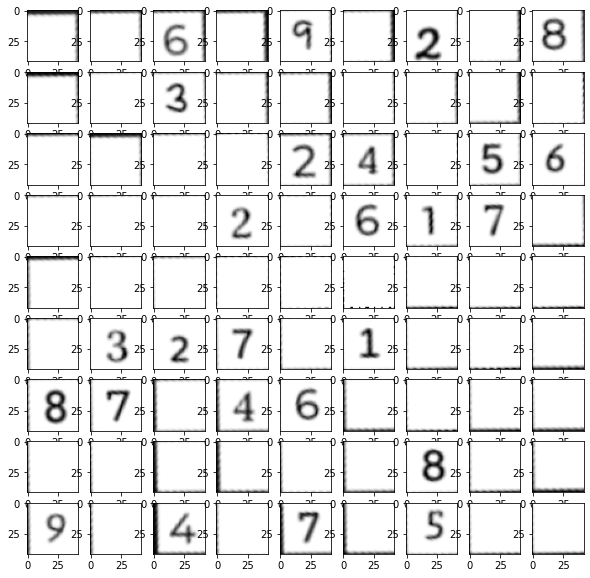

In [ ]:
# fig=plt.figure(figsize=(10, 10))

# columns = 9
# rows = 9
# tile_index = 0
# for i in range(1, columns*rows +1):
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(tiles[tile_index], cmap='gray')
#     tile_index+=1
# plt.show()

In [ ]:
from google.colab import output
def sound():
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
sound()
sound()

In [ ]:
solution = sudoku_solver(grid)

In [ ]:
def display_sudoku(sudoku):
    for i in range(9):
        for j in range(9):
            cell = sudoku[i][j]
            if cell == 0 or isinstance(cell, set):
                print('.',end='')
            else:
                print(cell,end='')
            if (j + 1) % 3 == 0 and j < 8:
                print(' |',end='')

            if j != 8:
                print('  ',end='')
        print()
        if (i + 1) % 3 == 0 and i < 8:
            print("--------+----------+---------")


In [ ]:
path = '/content/sudoku_train_images'
count = 0
for j in range(10):
  files = [i for i in os.listdir('/content/sudoku_train_images/'+str(j)+'/')]
  count += len(files)
  print(str(j),len(files))
print(count)

In [ ]:
def identify_number(image):
    dummy =  cv2.merge((image,image,image))

    image_resize = cv2.resize(dummy, (28,28))    
    image_resize_2 = image_resize.reshape(1,28,28,3)    

    loaded_model_pred = loaded_model.predict_classes(image_resize_2 , verbose = 0)

    return loaded_model_pred[0]

def extract_number(sudoku,file_name,original):
    # print('yes')
    sudoku = cv2.resize(sudoku, (450,450))
    original = cv2.resize(original, (450,450))

    file_name = file_name.split('.')[0]

    grid = np.zeros([9,9])
    for i in range(9):
        for j in range(9):
#            image = sudoku[i*50+3:(i+1)*50-3,j*50+3:(j+1)*50-3]
            image = sudoku[i*50:(i+1)*50,j*50:(j+1)*50]
            original_image = original[i*50:(i+1)*50,j*50:(j+1)*50]
            if image.sum() > 20000:
                grid[i][j] = identify_number(image)
                filename = "/content/images_inference/"+str(grid[i][j]).split('.')[0]+"/"+file_name+"_file_%d_%d.jpg"%(i, j)
                # print(filename)
                cv2.imwrite(filename,original_image)
            else:
                grid[i][j] = 0


TEMPORARY PIPELINE FOR TESTING


In [ ]:
json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/model_testtrain.h5")
print("Loaded saved model from disk.")

Loaded saved model from disk.


In [ ]:
path_img = '/content/data/test/images/'
files = [i for i in os.listdir(path_img)]
files.sort()
length = len(files)
for z in range(0,5000):
  image = cv2.imread(path_img+files[z])
  image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.copyMakeBorder(image.copy(),2,2,2,2,cv2.BORDER_CONSTANT,value=[0,0,0,0])
  image_bw = cv2.copyMakeBorder(image_bw.copy(),2,2,2,2,cv2.BORDER_CONSTANT,value=[0,0,0,0])
  # cv2_imshow(constant)
  image = cv2.resize(image,(600,600))
  image_bw = cv2.resize(image_bw,(600,600))
  preprocess = cv2.resize(preprocessImage(image), (600, 600))
  preprocess = cv2.bitwise_not(preprocess, preprocess)
  coords = getCoords(preprocess)
  preprocess = cv2.cvtColor(preprocess, cv2.COLOR_GRAY2BGR)
  coordsImage = preprocess.copy()
  warpedImage = warp(image_bw, coords)

  # Resize to 450 x 450
  warpedImage = cv2.resize(warpedImage, (450, 450))
  # plt_img(warpedImage)
  im = warpedImage.copy()
  img = []
  imgheight=im.shape[0]
  imgwidth=im.shape[1]
  M = imgheight//9
  N = imgwidth//9
  tiles = []
  pad = 4
  for y in range(0,imgheight,M):
      for x in range(0, imgwidth, N):
          y1 = y + M
          x1 = x + N
          tile = im[y+pad:y+M-pad,x+pad:x+N-pad]
          tiles.append(tile)
  for i in range(0,9):
    img.append(np.concatenate(tiles[9*i:9*(i+1)],axis=1))
  img = np.concatenate(img, axis=0)
  thresh = cv2.threshold(img, 130, 255, cv2.THRESH_BINARY_INV )[1]
  print(files[z])
  extract_number(thresh,files[z],img)


Extracting number from test images


In [ ]:
!zip -r  '/content/image_inference3500-4500.zip' '/content/images_inference/'

In [ ]:
%cp '/content/image_inference3500-4500.zip' '/content/drive/My Drive/'

TRAIN MODEL - CUSTOM IMAGES EXTRACTED FROM TRAIN DATA

In [ ]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [ ]:
json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/model_custom.h5")
print("Loaded saved model from disk.")

In [ ]:
%cd '/content/'
!mkdir sudoku_test_images
%cd 'sudoku_test_images'
!unzip '/content/sudoku_test_images.zip'

In [ ]:
datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)
train_generator = datagen.flow_from_directory(
    '/content/SolveSudoku/sudoku_test_images/sudoku_test_images',
    class_mode="categorical",
    target_size=(28,28),
    batch_size=128
    )

Found 23021 images belonging to 10 classes.


In [ ]:
loaded_model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=["accuracy"])
loaded_model.fit(train_generator, epochs = 10, verbose = 1, steps_per_epoch=179)

Epoch 1/10
179/179 [==============================] - 162s 902ms/step - loss: 0.0509 - accuracy: 0.9900
Epoch 2/10
179/179 [==============================] - 162s 902ms/step - loss: 0.0286 - accuracy: 0.9935
Epoch 3/10
179/179 [==============================] - 161s 900ms/step - loss: 0.0307 - accuracy: 0.9933
Epoch 4/10
179/179 [==============================] - 164s 916ms/step - loss: 0.0246 - accuracy: 0.9941
Epoch 5/10
179/179 [==============================] - 162s 902ms/step - loss: 0.0214 - accuracy: 0.9952
Epoch 6/10
179/179 [==============================] - 162s 907ms/step - loss: 0.0181 - accuracy: 0.9961
Epoch 7/10
179/179 [==============================] - 162s 908ms/step - loss: 0.0208 - accuracy: 0.9951
Epoch 8/10
179/179 [==============================] - 161s 901ms/step - loss: 0.0229 - accuracy: 0.9947
Epoch 9/10
179/179 [==============================] - 160s 891ms/step - loss: 0.0300 - accuracy: 0.9936
Epoch 10/10
179/179 [==============================] - 160s 892m

In [ ]:
# with open("model_testtrain.json", "w") as json_file:
#     json_file.write(model_json)
# serialize weights to HDF5
loaded_model.save_weights("model_testtrain.h5")
print("Saved model to disk")

Saved model to disk
